# Import Libraries

In [1]:
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import pickle
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report

# Read Dataset

Dataset used can be find in the following link: https://www.kaggle.com/datasets/arashnic/uplift-modeling

In [2]:
csv_file_path = os.path.join('..','..','..','..', 'data', 'criteo-uplift-v2.1.csv')
df = pd.read_csv(csv_file_path)
df.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
0,12.616365,10.059654,8.976429,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
1,12.616365,10.059654,9.002689,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
2,12.616365,10.059654,8.964775,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
3,12.616365,10.059654,9.002801,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
4,12.616365,10.059654,9.037999,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0


In [3]:
df[(df['treatment'] == 1) & (df['exposure'] == 1)]

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
540,12.896938,10.059654,8.214383,3.359763,10.280525,4.115453,-2.411115,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,1
548,16.689925,10.059654,8.214383,1.267425,10.280525,4.115453,-6.699321,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,1
715,12.781566,10.059654,8.215920,1.114982,11.561050,4.115453,-7.011752,4.833815,3.799079,45.054671,5.303177,-0.337358,1,1,1,1
808,13.018571,10.059654,8.301697,-0.413110,10.280525,4.115453,-10.143546,4.833815,3.876391,30.796373,5.300375,-0.168679,1,0,1,1
823,12.704505,10.059654,8.214383,0.604065,10.280525,4.115453,-8.058865,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13979498,12.758082,10.059654,8.454566,-1.450558,10.280525,3.013064,-18.209415,9.021503,3.878372,25.954644,5.300375,-0.168679,1,0,0,1
13979538,13.728129,10.059654,8.390505,-2.732200,10.280525,3.013064,-15.654324,11.858046,3.768021,42.253917,5.300375,-0.168679,1,0,1,1
13979560,18.115548,10.679513,8.544236,-2.369353,10.280525,2.230907,-17.796268,8.757396,3.808066,35.431533,5.300375,-0.168679,1,0,1,1
13979583,14.184428,10.059654,8.495848,2.293959,10.280525,4.115453,-4.595460,4.833815,3.872698,16.226044,5.300375,-0.168679,1,0,0,1


# EDA

In [4]:
# Review overview of the values of the dataset
df.describe()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
count,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07
mean,1.962030e+01,1.006998e+01,8.446582e+00,4.178923e+00,1.033884e+01,4.028513e+00,-4.155356e+00,5.101765e+00,3.933581e+00,1.602764e+01,5.333396e+00,-1.709672e-01,8.500001e-01,2.916680e-03,4.699200e-02,3.063122e-02
std,5.377464e+00,1.047557e-01,2.993161e-01,1.336645e+00,3.433081e-01,4.310974e-01,4.577914e+00,1.205248e+00,5.665958e-02,7.018975e+00,1.682288e-01,2.283277e-02,3.570713e-01,5.392748e-02,2.116217e-01,1.723164e-01
min,1.261636e+01,1.005965e+01,8.214383e+00,-8.398387e+00,1.028053e+01,-9.011892e+00,-3.142978e+01,4.833815e+00,3.635107e+00,1.319006e+01,5.300375e+00,-1.383941e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.261636e+01,1.005965e+01,8.214383e+00,4.679882e+00,1.028053e+01,4.115453e+00,-6.699321e+00,4.833815e+00,3.910792e+00,1.319006e+01,5.300375e+00,-1.686792e-01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.192341e+01,1.005965e+01,8.214383e+00,4.679882e+00,1.028053e+01,4.115453e+00,-2.411115e+00,4.833815e+00,3.971858e+00,1.319006e+01,5.300375e+00,-1.686792e-01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.443646e+01,1.005965e+01,8.723335e+00,4.679882e+00,1.028053e+01,4.115453e+00,2.944427e-01,4.833815e+00,3.971858e+00,1.319006e+01,5.300375e+00,-1.686792e-01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,2.674526e+01,1.634419e+01,9.051962e+00,4.679882e+00,2.112351e+01,4.115453e+00,2.944427e-01,1.199840e+01,3.971858e+00,7.529502e+01,6.473917e+00,-1.686792e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


f0            0
f1            0
f2            0
f3            0
f4            0
f5            0
f6            0
f7            0
f8            0
f9            0
f10           0
f11           0
treatment     0
conversion    0
visit         0
exposure      0
dtype: int64


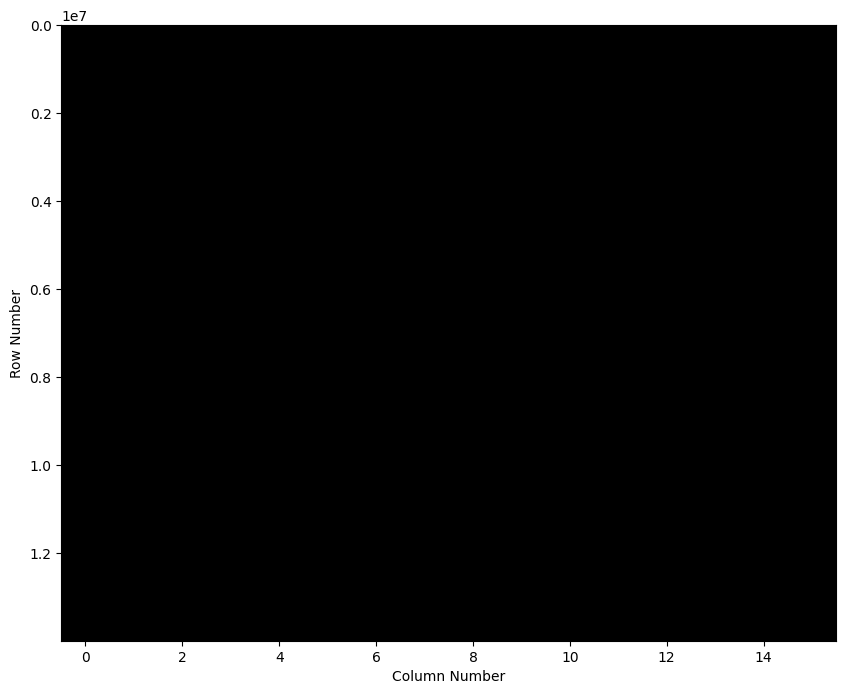

In [5]:
# Review Null values
print(df.isnull().sum())
plt.figure(figsize=(10, 8))
plt.imshow(df.isna(), aspect="auto", interpolation="nearest", cmap="gray")
plt.xlabel("Column Number")
plt.ylabel("Row Number");

<Axes: >

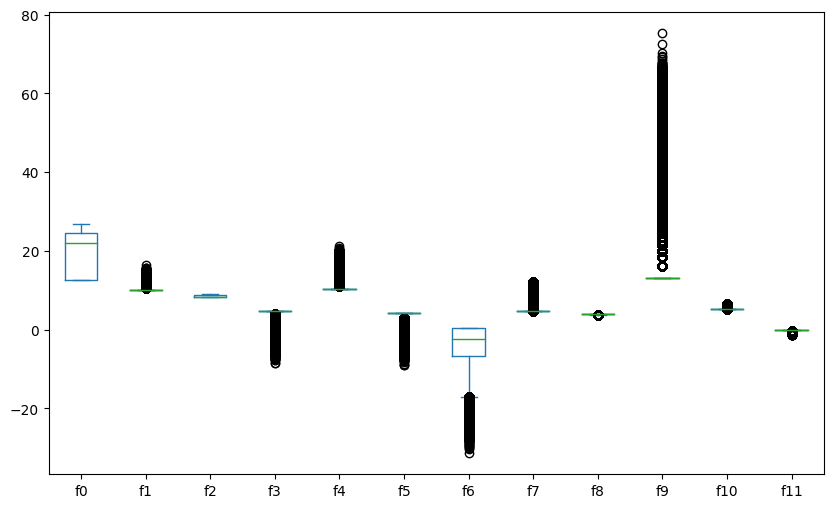

In [6]:
df.drop(['treatment','conversion','visit','exposure'], axis = 1).plot.box(figsize=(10,6))

treatment
1    0.85
0    0.15
Name: proportion, dtype: float64


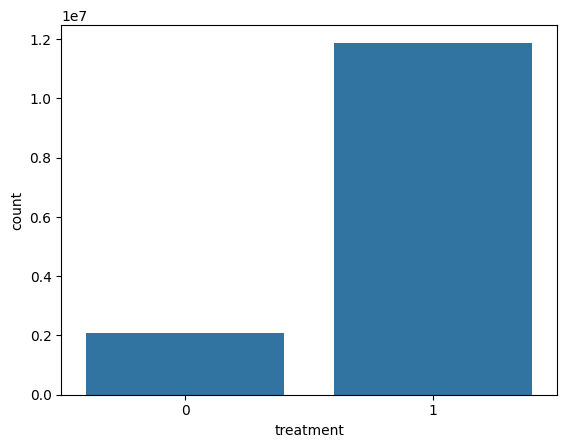

In [7]:
# Review imabalance of treatment variable
sns.countplot(x='treatment', data=df)
print(df['treatment'].value_counts(normalize = True))

exposure
0    0.969369
1    0.030631
Name: proportion, dtype: float64


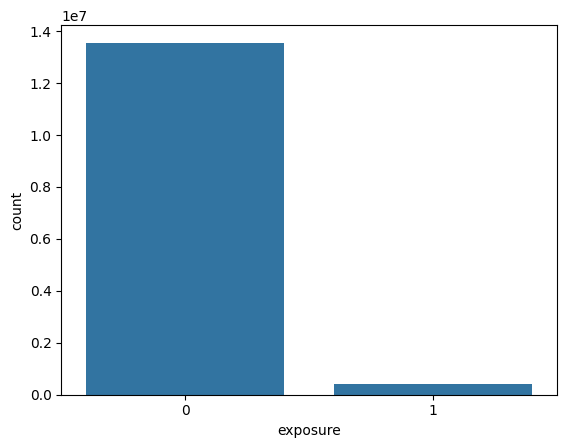

In [8]:
# Review imabalance of exposure variable
sns.countplot(x='exposure', data=df)
print(df['exposure'].value_counts(normalize = True))

conversion
0    0.997083
1    0.002917
Name: proportion, dtype: float64


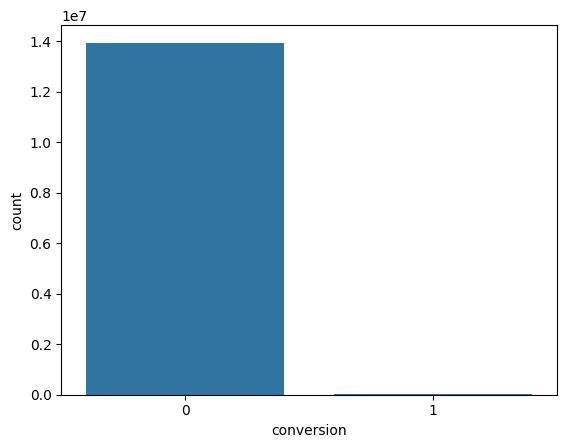

In [9]:
#Review imbalance of conversion variable
sns.countplot(x='conversion', data=df)
print(df['conversion'].value_counts(normalize = True))

visit
0    0.953008
1    0.046992
Name: proportion, dtype: float64


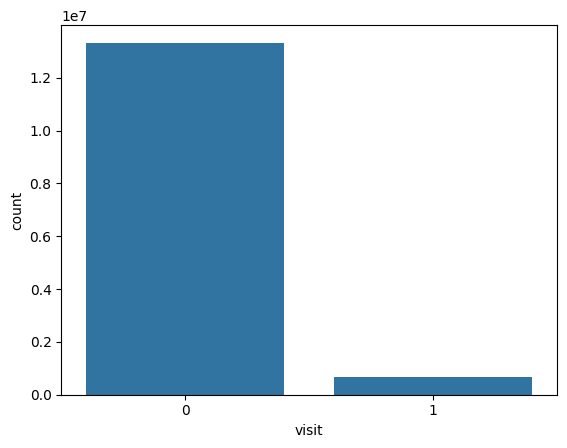

In [10]:
# Review imbalance of visit variable
sns.countplot(x='visit', data=df)
print(df['visit'].value_counts(normalize = True))

In [11]:
#Given the treatment, exposure and visits, how is the conversion?
df.groupby(['treatment','exposure','visit']).agg({'conversion':['mean','sum','count']})

conversion                 
                               mean    sum     count
treatment exposure visit                            
0         0        0       0.000000      0   2016832
                   1       0.050721   4063     80105
1         0        0       0.000000      0  11055129
                   1       0.034259  13680    399314
          1        0       0.000000      0    250702
                   1       0.129745  23031    177510

# Modeling

## Data Preparation

### Scaling

In [12]:
from sklearn import preprocessing

## Scaling features

scaled = preprocessing.scale(df.drop(['conversion','exposure'], axis = 1).values)
df_sca = pd.DataFrame(data=scaled, columns = df.drop(['conversion','exposure'], axis = 1).columns)
df_exposure = df['exposure']
df_conversion = df['conversion']

### Split Train Test

In [13]:
from sklearn.model_selection import train_test_split

train, test  = train_test_split(df, test_size=0.2, random_state=42, stratify=df['treatment'])

### Undersampling

In [14]:
# Random Undersampling (finding the majority class and undersampling it)
def random_under(df:pd.DataFrame, feature):
    target = df[feature].value_counts()
    if target.values[0]<target.values[1]:
        under = target.index.values[1]
    else: 
        under = target.index.values[0]
        
    df_0 = df[df[feature] != under]
    df_1 = df[df[feature] == under]
    
    df_treatment_under = df_1.sample(len(df_0))
    df_1 = pd.concat([df_treatment_under, df_0], axis=0)
    
    return df_1

In [15]:
train = random_under(train, 'treatment')

Class 0: 1677550
Class 1: 1677550
Proportion: 1 : 1


(array([0, 1]), [Text(0, 0, '1'), Text(1, 0, '0')])

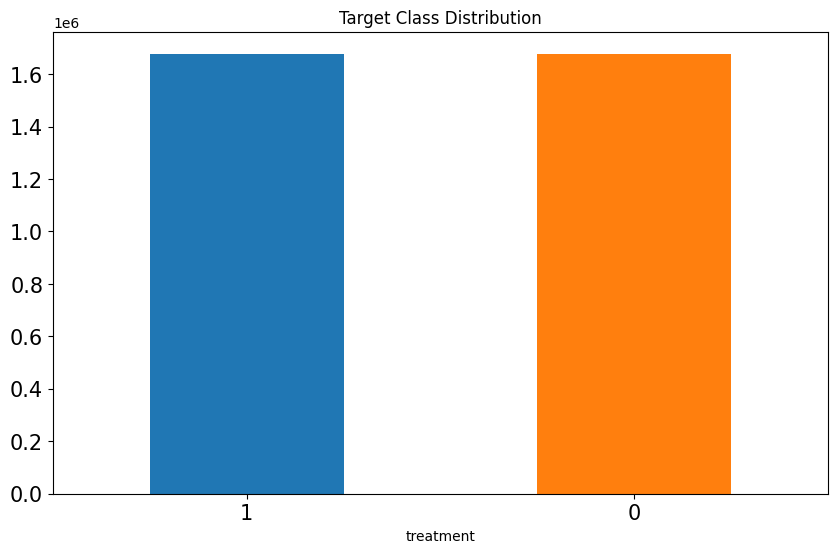

In [16]:
fig = plt.figure(figsize = (10,6))
new_target_count = train['treatment'].value_counts()
print('Class 0:', new_target_count[0])
print('Class 1:', new_target_count[1])
print('Proportion:', int(round(new_target_count[0] / new_target_count[1])), ': 1')
new_target_count.plot(kind='bar', title='Target Class Distribution', color=['#2077B4', '#FF7F0E'], fontsize = 15)
plt.xticks(rotation=0) 

## Model

𝑈𝑝𝑙𝑖𝑓𝑡 𝐿𝐺𝑊𝑈𝑀 = P(TR)/P(T) + P(CN)/P(C) - P(TN)/P(T) - P(CR)/P(C)

- TR: treatment-group responders
- CN: control-group non-responders
- TN: treatment-group non-responders
- CR: control-group responders

In [17]:
def target_class(df, treatment, target):
    #CN:
    df['target_class'] = 0 
    #CR:
    df.loc[(df[treatment] == 0) & (df[target] != 0),'target_class'] = 1 
    #TN:
    df.loc[(df[treatment] != 0) & (df[target] == 0),'target_class'] = 2 
    #TR:
    df.loc[(df[treatment] != 0) & (df[target] != 0),'target_class'] = 3 
    return df

In [18]:
train = target_class(train.drop(columns = ['conversion', 'exposure']), 'treatment', 'visit')
test = target_class(test.drop(columns = ['conversion', 'exposure']), 'treatment', 'visit')

In [19]:
X_train = train.drop(['visit','target_class'],axis=1)
y_train = train['target_class']
X_test = test.drop(['visit','target_class'],axis=1)
y_test = test['target_class']

In [20]:
def uplift_model(X_train,
                 X_test,
                 y_train,
                 y_test,
                 treatment_feature):

    result = pd.DataFrame(X_test).copy()    
    uplift_model = xgb.XGBClassifier().fit(X_train.drop(treatment_feature, axis=1), y_train)
    
    uplift_proba = uplift_model.predict_proba(X_test.drop(treatment_feature, axis=1))
    
    result['p_cn'] = uplift_proba[:,0] 
    result['p_cr'] = uplift_proba[:,1] 
    result['p_tn'] = uplift_proba[:,2] 
    result['p_tr'] = uplift_proba[:,3]
    
    result['uplift_score'] = result.eval('\
    p_cn/(p_cn + p_cr) \
    + p_tr/(p_tn + p_tr) \
    - p_tn/(p_tn + p_tr) \
    - p_cr/(p_cn + p_cr)')  

    # Put the result 
    result['target_class'] = y_test
    
    return result

In [21]:
result = uplift_model(X_train, X_test, y_train, y_test, 'treatment')
result.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,p_cn,p_cr,p_tn,p_tr,uplift_score,target_class
6304619,21.890358,10.059654,8.214383,4.679882,10.280525,4.115453,-4.595460,4.833815,3.971858,13.190056,5.300375,-0.168679,0,0.502924,0.000265,0.496606,0.000205,-0.000228,0
4045638,15.995929,10.059654,8.214383,0.973841,10.280525,4.115453,-7.301017,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0.501510,0.001366,0.495042,0.002082,0.002943,2
5767216,19.111923,10.059654,8.214383,3.359763,10.280525,4.115453,-2.411115,4.833815,3.971858,13.190056,5.300375,-0.168679,0,0.503014,0.000632,0.495430,0.000924,0.001214,0
9668584,12.870404,10.059654,8.979246,-1.025575,10.280525,4.115453,-16.175537,4.833815,3.902645,13.190056,5.300375,-0.168679,1,0.418387,0.009957,0.531339,0.040317,0.094564,2
830405,21.992620,10.059654,8.214383,4.679882,10.280525,4.115453,-2.411115,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0.502218,0.000235,0.497314,0.000234,0.000004,2


## Save Model

In [22]:
model = xgb.XGBClassifier(objective='multi:softprob', num_class=3, random_state=42)
model.fit(X_train.drop('treatment', axis=1), y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=3,
              num_parallel_tree=None, ...)

In [23]:
with open('xgboost_model.pkl', 'wb') as f:
    pickle.dump(model, f)


In [24]:
csv_file_path = os.path.join('..', 'data', 'test_dataset.csv')
df_testing = pd.read_csv(csv_file_path)
df_testing

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11
0,21.890358,10.059654,8.214383,4.679882,10.280525,4.115453,-4.595460,4.833815,3.971858,13.190056,5.300375,-0.168679
1,15.995929,10.059654,8.214383,0.973841,10.280525,4.115453,-7.301017,4.833815,3.971858,13.190056,5.300375,-0.168679
2,19.111923,10.059654,8.214383,3.359763,10.280525,4.115453,-2.411115,4.833815,3.971858,13.190056,5.300375,-0.168679
3,12.870404,10.059654,8.979246,-1.025575,10.280525,4.115453,-16.175537,4.833815,3.902645,13.190056,5.300375,-0.168679
4,21.992620,10.059654,8.214383,4.679882,10.280525,4.115453,-2.411115,4.833815,3.971858,13.190056,5.300375,-0.168679
...,...,...,...,...,...,...,...,...,...,...,...,...
495,14.467730,10.059654,8.214383,3.907662,10.280525,4.115453,-1.288207,4.833815,3.971858,13.190056,5.300375,-0.168679
496,23.145685,10.059654,8.428971,4.679882,11.561050,2.230907,-1.288207,9.973772,3.771810,38.005580,5.884116,-0.267350
497,19.496515,10.059654,8.214383,2.934780,10.280525,4.115453,-3.282109,4.833815,3.971858,13.190056,5.300375,-0.168679
498,12.616365,10.059654,8.480753,4.679882,10.280525,4.115453,0.294443,4.833815,3.892853,27.760385,5.300375,-0.168679


In [25]:
import pickle
import pandas as pd

# Load model
with open('xgboost_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

# Get proba and predictions
uplift_proba = loaded_model.predict_proba(X_test.drop('treatment', axis=1))
predictions = loaded_model.predict(X_test.drop('treatment', axis=1))

# Create dataframre with results
result = X_test.copy()

result['p_cn'] = uplift_proba[:, 0]
result['p_cr'] = uplift_proba[:, 1]
result['p_tn'] = uplift_proba[:, 2]
result['p_tr'] = uplift_proba[:, 3]

result['uplift_score'] = result.eval('\
    p_cn/(p_cn + p_cr) \
    + p_tr/(p_tn + p_tr) \
    - p_tn/(p_tn + p_tr) \
    - p_cr/(p_cn + p_cr)')


result['predictions'] = predictions
result['target_class'] = y_test
result

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,p_cn,p_cr,p_tn,p_tr,uplift_score,predictions,target_class
6304619,21.890358,10.059654,8.214383,4.679882,10.280525,4.115453,-4.595460,4.833815,3.971858,13.190056,5.300375,-0.168679,0,0.502924,0.000265,0.496606,0.000205,-0.000228,0,0
4045638,15.995929,10.059654,8.214383,0.973841,10.280525,4.115453,-7.301017,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0.501510,0.001366,0.495042,0.002082,0.002943,0,2
5767216,19.111923,10.059654,8.214383,3.359763,10.280525,4.115453,-2.411115,4.833815,3.971858,13.190056,5.300375,-0.168679,0,0.503014,0.000632,0.495430,0.000924,0.001214,0,0
9668584,12.870404,10.059654,8.979246,-1.025575,10.280525,4.115453,-16.175537,4.833815,3.902645,13.190056,5.300375,-0.168679,1,0.418387,0.009957,0.531339,0.040317,0.094564,2,2
830405,21.992620,10.059654,8.214383,4.679882,10.280525,4.115453,-2.411115,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0.502218,0.000235,0.497314,0.000234,0.000004,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7779979,12.616365,10.059654,8.408846,4.679882,11.561050,4.115453,0.294443,4.833815,3.755446,39.022417,6.075978,-0.168679,1,0.257311,0.232574,0.243536,0.266579,0.095669,3,3
9665084,25.334315,10.059654,8.417949,4.679882,10.280525,4.115453,-5.987667,4.833815,3.851258,31.477540,5.300375,-0.168679,1,0.445510,0.076879,0.408863,0.068747,-0.006458,0,2
613157,24.388364,10.059654,8.214383,4.679882,10.280525,4.115453,-6.359690,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0.500297,0.000256,0.498941,0.000506,0.001001,0,2
12025698,12.616365,10.059654,8.774683,4.679882,10.280525,4.115453,0.294443,4.833815,3.855652,13.190056,5.300375,-0.168679,1,0.486412,0.018972,0.479088,0.015529,-0.012288,0,2


## Model Eval

As seen in the following section, the model's performance is quite poor. We opted to use macro average metrics to obtain precision and recall, in order to give equal importance to all classes. Given that this is an imbalanced dataset, this directly affects the model's evaluation. However, even considering this, the performance remains quite low. Despite this, we chose to continue using it solely for the purpose of proceeding with the web application exercise. Nonetheless, future updates will focus on improving the model.

In [30]:
# accuracy
accuracy = accuracy_score(y_test, predictions)

# Precision and Recall by class
precision_per_class = precision_score(y_test, predictions, average=None)
recall_per_class = recall_score(y_test, predictions, average=None)

# Precision and Recall general
precision_general = precision_score(y_test, predictions, average='macro')
recall_general = recall_score(y_test, predictions, average='macro')
accuracy_general = accuracy

# Print Metrics
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision per class: {precision_per_class}')
print(f'Recall per class: {recall_per_class}')
print(f'Precision: {precision_general:.2f}')
print(f'Recall: {recall_general:.2f}')


report = classification_report(y_test, predictions)
print('Reporte de Clasificación:\n', report)

Accuracy: 0.26
Precision per class: [0.14891808 0.09066787 0.77977832 0.55239985]
Recall per class: [0.83863883 0.0875625  0.15754388 0.2489039 ]
Precision: 0.39
Recall: 0.33
Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.15      0.84      0.25    403387
           1       0.09      0.09      0.09     16000
           2       0.78      0.16      0.26   2261351
           3       0.55      0.25      0.34    115181

    accuracy                           0.26   2795919
   macro avg       0.39      0.33      0.24   2795919
weighted avg       0.68      0.26      0.26   2795919



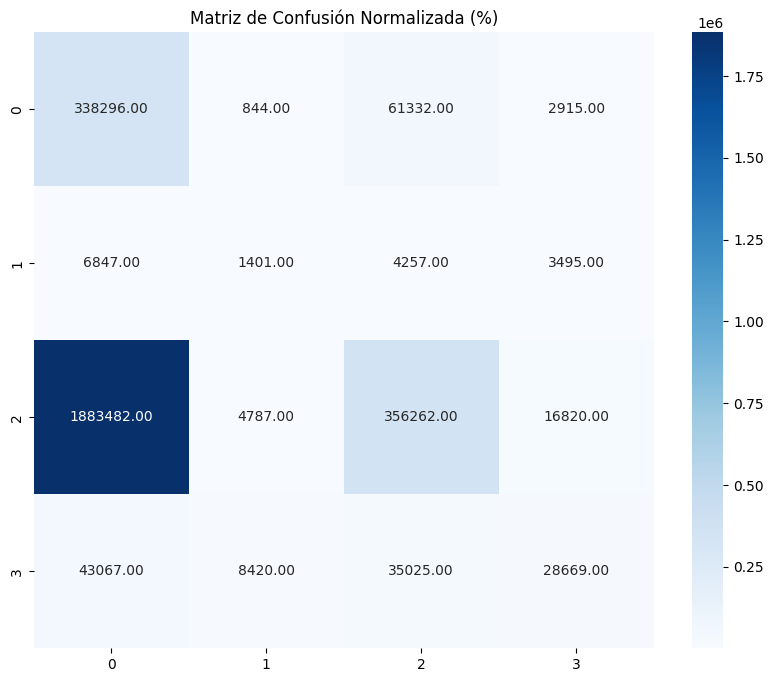

In [27]:
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(y_test, predictions)
cm_normalized = cm#.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

df_cm = pd.DataFrame(cm_normalized, index=np.unique(y_test), columns=np.unique(y_test))

#Plotting
plt.figure(figsize=(10, 8))
sns.heatmap(df_cm, annot=True, fmt=".2f", cmap='Blues', cbar=True, 
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Matriz de Confusión Normalizada (%)')
plt.show()